### 任务描述
信用评分卡模型在信用风险评估及金融风控领域得到广泛的应用，是一种以分数的形式来对用户进行评估的方法，通常评分越高代表用户的信用越好，从而风险也就越小。常见的信用评分卡有：A卡（申请评分卡）、B卡（行为评分卡）、C卡（催收评分卡）等，三者分别侧重贷前、贷中、贷后三个阶段，具体含义如引用所示。本案例选用的数据集主要涉及借款人的行为评级，因此任务是建立行为评分卡模型，该评分卡可以根据借款人在借贷之后的行为表现，预测其未来违约的概率。

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data=pd.read_csv('./data/datasets/cs-training.csv')
data.head(10)

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,6,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,7,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,8,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,9,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,10,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


#### 由于变量名太多，简化名字，同时删除无用列unnamed

In [2]:
data=data.iloc[:,1:]
data.columns=['Label','RevolvingRatio','Age','30-59D','DebtRatio','MonthlyIncome','OpenL','90D','RealEstate','60-89D','Dependents']
data.head(10)

,Label,RevolvingRatio,Age,30-59D,DebtRatio,MonthlyIncome,OpenL,90D,RealEstate,60-89D,Dependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
5,0,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0
6,0,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0
7,0,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0
8,0,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN
9,0,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0


### 3.数据预处理

#### 3.1缺失值处理

In [3]:
data.isnull().sum()

Label                 0
RevolvingRatio        0
Age                   0
30-59D                0
DebtRatio             0
MonthlyIncome     29731
OpenL                 0
90D                   0
RealEstate            0
60-89D                0
Dependents         3924
dtype: int64

In [4]:
data.isnull().mean()

Label             0.000000
RevolvingRatio    0.000000
Age               0.000000
30-59D            0.000000
DebtRatio         0.000000
MonthlyIncome     0.198207
OpenL             0.000000
90D               0.000000
RealEstate        0.000000
60-89D            0.000000
Dependents        0.026160
dtype: float64

- 可以发现只有月收入和家属人数有缺失，月收入缺失较多不能直接删除，家属人数可以直接删除，采用随机森林进行建模填充月收入，选择用众数填充家属人数

In [8]:
#MonthlyIncome特征处理
from sklearn.ensemble import RandomForestRegressor
rfDf=data.iloc[:,[5,1,2,3,4,6,7,8,9]]
rfDf_train=rfDf.loc[rfDf['MonthlyIncome'].notnull()]
rfDf_test=rfDf.loc[rfDf['MonthlyIncome'].isnull()]

#划分训练数据和标签
X=rfDf_train.iloc[:,1:]
y=rfDf_train.iloc[:,0]

#训练
rf=RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,n_jobs=-1)
rf.fit(X,y)
pred=rf.predict(rfDf_test.iloc[:,1:]).round(0)
data.loc[(data['MonthlyIncome'].isnull()),'MonthlyIncome']=pred
print(rfDf['MonthlyIncome'].describe())

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64


In [9]:
#Dependents特征处理
data['Dependents'].fillna(data['Dependents'].mode()[0],inplace=True)
print(data['Dependents'].describe())

count    150000.000000
mean          0.737413
std           1.107021
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: Dependents, dtype: float64


#### 3.2异常值处理

- 用箱型图直观的观察每一列特征，找到偏离正常范围较大的异常值

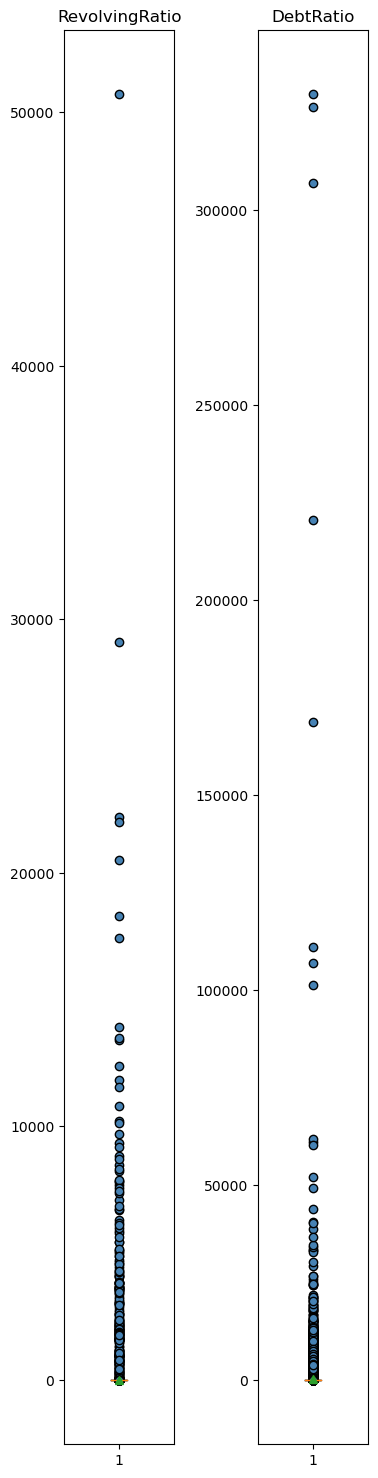

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#分析百分比特征
fig,axis=plt.subplots(1,2,figsize=(4,15),dpi=100)

axis[0].boxplot(list(data['RevolvingRatio']),showmeans=True,flierprops={'marker':'o','markerfacecolor':'steelblue'})
axis[0].set_title('RevolvingRatio')

axis[1].boxplot(list(data['DebtRatio']),showmeans=True, flierprops = {"marker":"o","markerfacecolor":"steelblue"})
axis[1].set_title('DebtRatio')
plt.tight_layout(pad=1.5)
plt.show()

- RevolvingRatio代表信贷额度除以总额度的百分比，DebtRatio表示每月的负债比率，从实际意义出发进行理解这两者的取值范围都应该在【0，1】之间将大于0，1的值用[0,1]之间的均值进行填充

In [18]:
#RevolvingRatio
ruulDf=data[data['RevolvingRatio']<=1]
ruul_mean=ruulDf['RevolvingRatio'].mean()
data.loc[data['RevolvingRatio']>1,'RevolvingRatio']=ruul_mean

#debtRatio
ruulDf=data[data['DebtRatio']<=1]
ruul_mean=ruulDf['DebtRatio'].mean()
data.loc[data['DebtRatio']>1,'DebtRatio']=ruul_mean

#### 3.2.2逾期特征

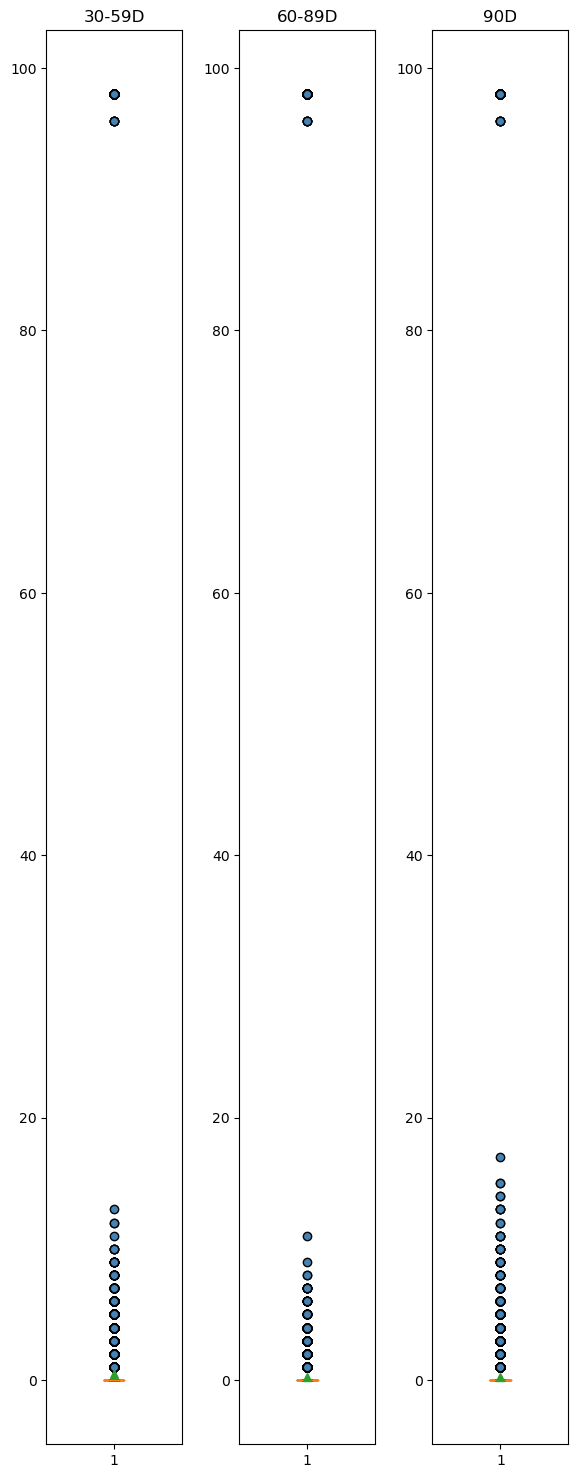

In [23]:
fig,axis=plt.subplots(1,3,figsize=(6,15),dpi=100)

axis[0].boxplot(list(data['30-59D']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[0].set_title('30-59D')

axis[1].boxplot(list(data['60-89D']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[1].set_title('60-89D')

axis[2].boxplot(list(data['90D']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[2].set_title('90D')
plt.tight_layout(pad=1.5)
plt.show()

- 可以发现逾期接近100次的可以视为异常值

In [25]:
row1=data[data['30-59D']>80].shape[0]
row2=data[data['60-89D']>80].shape[0]
row3=data[data['90D']>80].shape[0]
print(row1,'/n',row2,row3)

269 /n 269 269


In [27]:
#查看是否属于同样的269样本
sameDf=data[data['30-59D']>80]
sameDf=sameDf[sameDf['60-89D']>80]
sameDf=sameDf[sameDf['90D']>80]
sameDf.shape[0]

269

- 可以发现269条数据同时在三个列为异常值，只占很小一部分，直接删除

In [28]:
data.drop(data[data['30-59D']>80].index,inplace=True)
data.shape

(149731, 11)

Text(0.5, 1.0, 'Age')

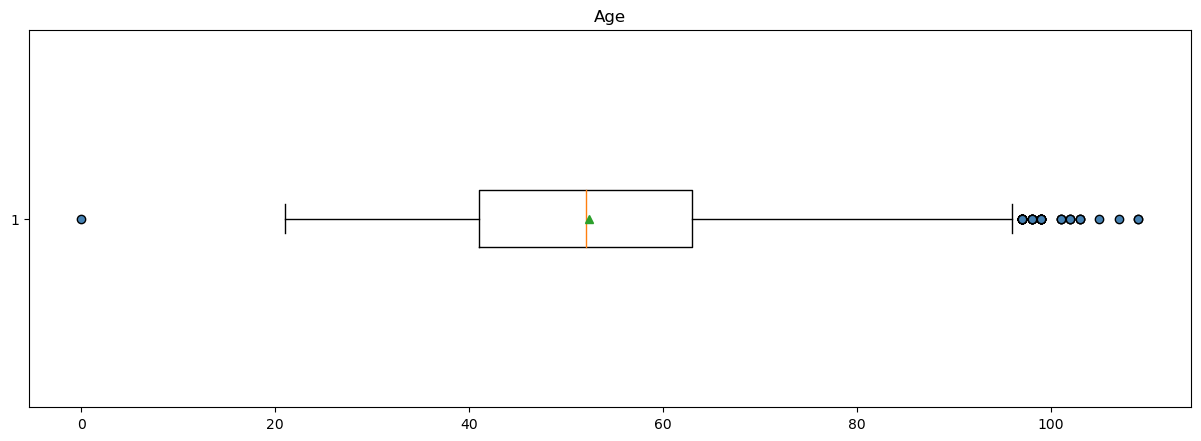

In [33]:
plt.figure(figsize=(15,5),dpi=100)
plt.boxplot(list(data['Age']),vert=False,showmeans=True,flierprops = {"marker":"o","markerfacecolor":"steelblue"})
plt.title('Age')


- 从上图可以明显看出，0为异常值只有一个直接删除，100左右的也应该删除

In [34]:
#箱型图边界
q1=data['Age'].describe()['25%']
q3=data['Age'].describe()['75%']
iqr=q3-q1
print('上线',q3+iqr*1.5)
print('下线',q1-iqr*1.5)

上线 96.0
下线 8.0


In [35]:
data[data['Age']<8].shape[0]

1

In [36]:
data[data['Age']>96].shape[0]

45

In [37]:
#删除年龄特征异常值
data.drop(data[data['Age']==0].index,inplace=True)
data.drop(data[data['Age']>96].index,inplace=True)
data.shape[0]

149685

#### 3.2.4其余特征

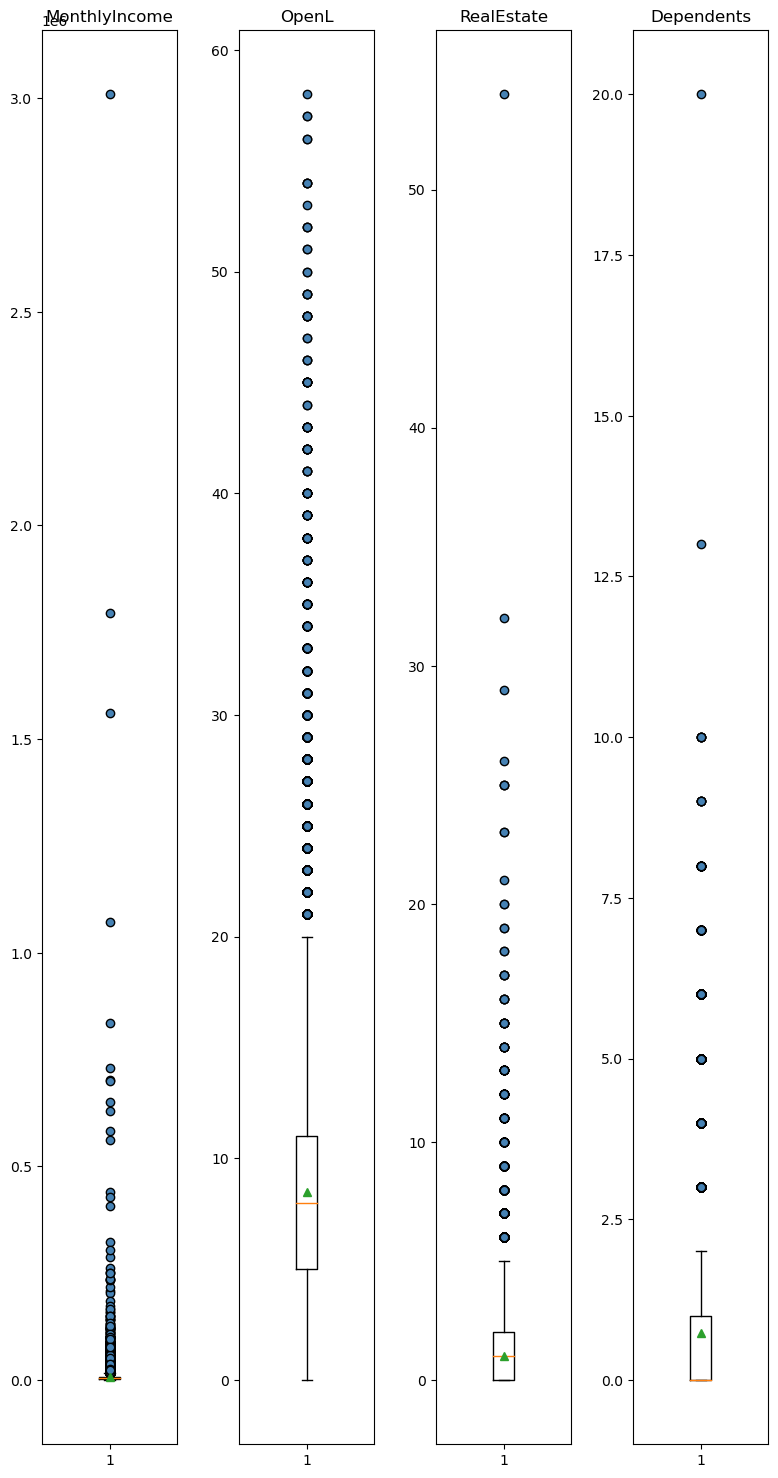

In [38]:
fig,axis=plt.subplots(1,4,figsize=(8,15),dpi=100)

axis[0].boxplot(list(data['MonthlyIncome']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[0].set_title('MonthlyIncome')

axis[1].boxplot(list(data['OpenL']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[1].set_title('OpenL')

axis[2].boxplot(list(data['RealEstate']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[2].set_title('RealEstate')

axis[3].boxplot(list(data['Dependents']),showmeans=True,flierprops={"marker":"o","markerfacecolor":"steelblue"})
axis[3].set_title('Dependents')
plt.tight_layout(pad=1.5)
plt.show()

- 从上图可以看出，4列均有一定数量的异常值，且异常值分布在箱型图的其中一侧，暂时先不做处理，后续还有特征分箱环节，分箱可以直接将这些异常值限制在最右侧箱体中进行编码，而不会用到原始特征值，这样也可以起到处理异常值的作用

## 4.特征工程
在传统的信用卡评分中，在特征工程环节，对特征往往采用"分箱-WOE编码-通过IV值选择'流程进行处理

### 4.1特征相关性分析

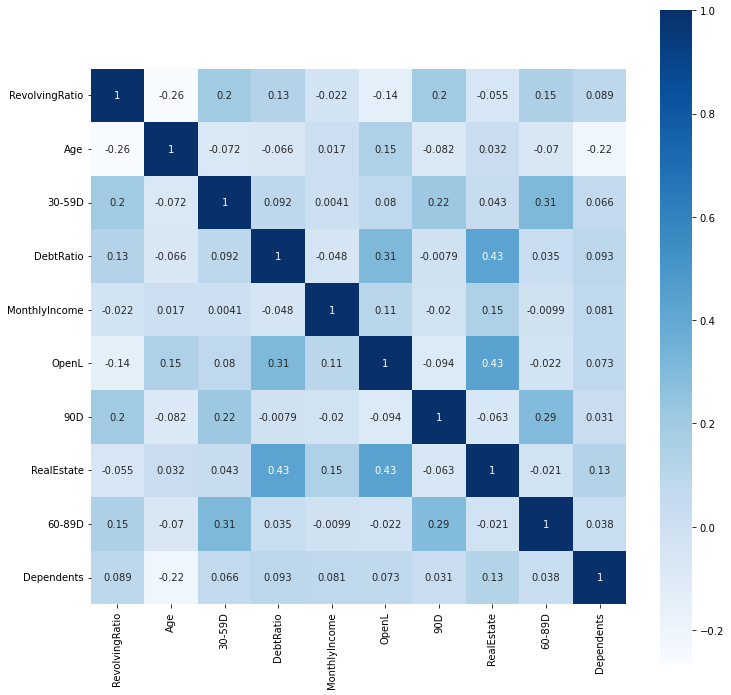

In [46]:
nu_fea=list(data.columns[1:])
pearson_mat=data[nu_fea].corr(method='pearson')

plt.figure(figsize=(12,12))
sns.heatmap(pearson_mat,annot=True,square=True,cmap='Blues')
plt.show()

- 可以观察到各个特征之间的相关性较小，可以初步判定特征之间不存在明显的多重共线性问题(相关性绝对值小于0.6），暂时不需要删除多余特征

### 4.2 新特征构建

原始数据集中有10列特征，可以再构建一些新的连续值特征作为备选

In [49]:
#IncAvg:家庭人均月收入
data['IncAvg']=data['MonthlyIncome']/(data['Dependents']+1)
#MonthlyDept:每月债务
data['MonthlyDept']=data['MonthlyIncome']*data['DebtRatio']
#DeptAvg:人均应偿还债务
data['DeptAvg']=data['MonthlyDept']/(data['Dependents']+1)
data.head()

,Label,RevolvingRatio,Age,30-59D,DebtRatio,MonthlyIncome,OpenL,90D,RealEstate,60-89D,Dependents,IncAvg,MonthlyDept,DeptAvg
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,3040.0,7323.197016,2441.065672
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,1300.0,316.878123,158.439061
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,3042.0,258.914887,258.914887
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,3300.0,118.963951,118.963951
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,63588.0,1584.975094,1584.975094


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149685 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Label           149685 non-null  int64  
 1   RevolvingRatio  149685 non-null  float64
 2   Age             149685 non-null  int64  
 3   30-59D          149685 non-null  int64  
 4   DebtRatio       149685 non-null  float64
 5   MonthlyIncome   149685 non-null  float64
 6   OpenL           149685 non-null  int64  
 7   90D             149685 non-null  int64  
 8   RealEstate      149685 non-null  int64  
 9   60-89D          149685 non-null  int64  
 10  Dependents      149685 non-null  float64
 11  IncAvg          149685 non-null  float64
 12  MonthlyDept     149685 non-null  float64
 13  DeptAvg         149685 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 17.1 MB


### 4.3分箱

- 由于全是连续型特征，所以这里可以采用特征分箱进行处理

- 这里采用最优分箱结合自定义分箱的方法进行处理

#### 4.6.1 最优分箱

In [53]:
from scipy.stats import stats
def optimal_bins(Y,X,n):
    """
    param Y:目标变量
    param X:待分箱特征
    param n分箱数初始值
    return 统计值，分享边界值列表，woe值，iv值
    
    """
    r=0
    total_bad=Y.sum()
    total_good=Y.count()-total_bad
    #分箱过程
    while np.abs(r)<1:
        df1=pd.DataFrame({'X':X,'Y':Y,'bin':pd.qcut(X,n,duplicates='drop')})
        df2=df1.groupby('bin')
        r,p=stats.spearmanr(df2.mean().X,df2.mean().Y)
        n=n-1
    #计算woe值和iv值
    df3=pd.DataFrame()
    df3['min_'+X.name]=df2.min().X
    df3['max_'+X.name]=df2.max().X
    df3['sum']=df2.sum().Y
    df3['total']=df2.count().Y
    df3['rage']=df2.mean().Y
    df3['badattr']=df3['sum']/total_bad
    df3['goodattr']=(df3['total']-df3['sum'])/total_good
    df3['woe']=np.log(df3['badattr']/df3['goodattr'])
    iv=((df3['badattr']-df3['goodattr'])*df3['woe']).sum()
    df3=df3.sort_values(by='min_'+X.name).reset_index(drop=True)
    #分箱边界值列表
    cut=[]
    cut.append(float('-inf'))
    for i in range(1,n+1):
        qua=X.quantile(i/(n+1))
        cut.append(round(qua,6))
    cut.append(float('inf'))
    woe=list(df3['woe'])
    return df3,cut,woe,iv

In [55]:
#观察RevolvingRatio特征分箱情况
rrDf,cut_rr,woe_rr,iv_rr=optimal_bins(data.Label,data.RevolvingRatio,n=10)
rrDf

,min_RevolvingRatio,max_RevolvingRatio,sum,total,rage,badattr,goodattr,woe
0,0.000000,0.029805,687,37422,0.018358,0.069563,0.262751,-1.328981
1,0.029808,0.153559,744,37421,0.019882,0.075334,0.262336,-1.247694
2,0.153560,0.504270,2818,37421,0.075305,0.285338,0.247502,0.142257
3,0.504272,1.000000,5627,37421,0.150370,0.569765,0.227410,0.918468


In [56]:
cut_rr

[-inf, 0.029805, 0.153559, 0.50427, inf]

In [57]:
# MonthlyIncome特征
miDf,cut_mi,woe_mi,iv_mi = optimal_bins(data.Label,data.MonthlyIncome,n=10)
print("MonthlyIncome特征分箱情况：", cut_mi)
# Age特征
ageDf,cut_age,woe_age,iv_age = optimal_bins(data.Label,data.Age,n=10)
print("Age特征分箱情况：", cut_age)
# DebtRatio特征
drDf,cut_dr,woe_dr,iv_dr = optimal_bins(data.Label,data.DebtRatio,10)
print("DebtRatio特征分箱情况：", cut_dr)

MonthlyIncome特征分箱情况： [-inf, 3300.0, 6750.0, inf]
Age特征分箱情况： [-inf, 33.0, 40.0, 45.0, 50.0, 54.0, 59.0, 64.0, 71.0, inf]
DebtRatio特征分箱情况： [-inf, 0.238944, 0.312212, inf]


In [58]:
### 新特征
# IncAvg特征
newDf1,cut_new1,woe_new1,iv_new1 = optimal_bins(data.Label, data.IncAvg, 10)
# MonthlyDept特征
newDf2,cut_new2,woe_new2,iv_new2 = optimal_bins(data.Label, data.MonthlyDept, 10)
# DeptAvg特征
newDf3,cut_new3,woe_new3,iv_new3 = optimal_bins(data.Label, data.DeptAvg, 10)

print("IncAvg特征特征分箱情况：", cut_new1)
print("MonthlyDept特征分箱情况：", cut_new2)
print("DeptAvg特征分箱情况：", cut_new3)

IncAvg特征特征分箱情况： [-inf, 1700.0, 2959.0, 5400.0, inf]
MonthlyDept特征分箱情况： [-inf, inf]
DeptAvg特征分箱情况： [-inf, 351.20217, 773.917466, 1591.840815, inf]


- 可见三列中MonthlyDept不适合使用最优分箱方法，需要寻找新的分箱方法进行处理

In [59]:
df1,cut1,woe1,iv1 = optimal_bins(data.Label,data['30-59D'],n=10)
print(cut1)
df2,cut2,woe2,iv2 = optimal_bins(data.Label,data.OpenL,n=10)
print(cut2)
df3,cut3,woe3,iv3 = optimal_bins(data.Label,data['90D'],n=10)
print(cut3)
df4,cut4,woe4,iv4 = optimal_bins(data.Label,data['60-89D'],n=10)
print(cut4)
df5,cut5,woe5,iv5 = optimal_bins(data.Label,data.RealEstate,n=10)
print(cut5)
df6,cut6,woe6,iv6 = optimal_bins(data.Label,data.Dependents,n=10)
print(cut6)

[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, inf]
[-inf, inf]
[-inf, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, inf]


- 对于其他六列原始特征，用最优分箱计算效果同样较差

#### 4.6.2自定义分箱

- 原因可能是某些特征值占比过高，阈值设置不合适等等，因此不能满足最优分段的要求

In [65]:
##自定义分享函数
def custom_bins(Y,X,binList):
    r=0
    total_bad=Y.sum()
    total_good=Y.count()-total_bad
    #等距分箱
    df1=pd.DataFrame({'X':X,'Y':Y,'bin':pd.cut(X,binList)})
    df2=df1.groupby('bin',as_index=True)
    r,p=stats.spearmanr(df2.mean().X,df2.mean().Y)
    #计算woe值和iv值
    df3=pd.DataFrame()
    df3['min_'+X.name]=df2.min().X
    df3['max_'+X.name]=df2.max().X
    df3['sum']=df2.sum().Y
    df3['total']=df2.count().Y
    df3['rate']=df2.mean().Y
    df3['badattr']=df3['sum']/total_bad
    df3['goodattr']=(df3['total']-df3['sum'])/total_good
    df3['woe']=np.log(df3['badattr']/df3['goodattr'])
    iv=((df3['badattr']-df3['goodattr'])*df3['woe']).sum()
    df3=df3.sort_values(by='min_'+X.name).reset_index(drop=True)
    woe=list(df3['woe'])
    return df3,woe,iv

In [61]:
ninf=float('-inf')
pinf=float('inf')
cut_thirty = [ninf, 0, 1, 3, 5, pinf]    # 30-59D特征
cut_open = [ninf,1, 2, 3, 5, pinf]    # OpenL特征
cut_ninety = [ninf, 0, 1, 3, 5, pinf]    # 90D特征
cut_re = [ninf, 0, 1, 2, 3, pinf]    # RealEstate特征
cut_sixty = [ninf, 0, 1, 3, pinf]    # 60-89D特征
cut_dpt = [ninf, 0, 1, 2, 3, 5, pinf]    # Dependents特征

In [62]:
#查看新特征统计
data['MonthlyDept'].describe()

count    149685.000000
mean       1706.803818
std        1739.175493
min           0.000000
25%         413.852301
50%        1208.640180
75%        2518.413491
max       57086.823924
Name: MonthlyDept, dtype: float64

In [63]:
cut_new2=[ninf,414,1209,2519,pinf]

In [66]:
### 计算统计值、woe和iv
thirtyDf, woe_thirty, iv_thirty = custom_bins(data.Label, data['30-59D'], cut_thirty)    # 30-59D特征
openDf, woe_open, iv_open = custom_bins(data.Label, data.OpenL, cut_open)    # OpenL特征
ninetyDf, woe_ninety, iv_ninety = custom_bins(data.Label, data['90D'], cut_ninety)    # 90D特征
reDf, woe_re, iv_re = custom_bins(data.Label, data.RealEstate, cut_re)    # RealEstate特征
sixtyDf, woe_sixty, iv_sixty = custom_bins(data.Label, data['60-89D'], cut_sixty)    # 60-89D特征
dptDf, woe_dpt, iv_dpt = custom_bins(data.Label, data.Dependents, cut_dpt)    # Dependents特征
newDf2, woe_new2, iv_new2 = custom_bins(data.Label, data.MonthlyDept, cut_new2)    # 新特征MonthlyDept

#### 4.6.3 IV值筛选特征

In [67]:
#查看Iv值
ivDf=pd.DataFrame(columns=['feature','iv'])
fealist=list(data.columns[1:])
ivList=[iv_rr, iv_age, iv_thirty, iv_dr, iv_mi, iv_open, iv_ninety, iv_re, iv_sixty, iv_dpt, iv_new1, iv_new2, iv_new3]
for i,x in enumerate(fealist):
    ivDf.loc[i,'feature']=x
    ivDf.loc[i,'iv']=ivList[i]
ivDf=ivDf.sort_values(by='iv',ascending=False).reset_index(drop=True)
ivDf

,feature,iv
0,90D,0.847691
1,RevolvingRatio,0.809891
2,30-59D,0.723697
3,60-89D,0.566693
4,Age,0.251094
5,IncAvg,0.075329
6,OpenL,0.070119
7,RealEstate,0.05617
8,MonthlyIncome,0.042346
9,Dependents,0.03729


- 根据iv值表格，小于0.1的特征可视为弱特征，由于评分卡需要的特征可以较少，所以这里舍去iv值小于0.1的特征

In [71]:
### WOE编码
data['90D'] = pd.cut(data['90D'], bins=cut_ninety, labels=woe_ninety)    # 90D特征
data['RevolvingRatio'] = pd.cut(data['RevolvingRatio'], bins=cut_rr, labels=woe_rr)    # RevolvingRatio特征
data['30-59D'] = pd.cut(data['30-59D'], bins=cut_thirty, labels=woe_thirty)    # 30-59D特征
data['60-89D'] = pd.cut(data['60-89D'], bins=cut_sixty, labels=woe_sixty)    # 60-89D特征
data['Age'] = pd.cut(data['Age'], bins=cut_age, labels=woe_age)    # Age特征

# 特征选择
data = data[['Label', '90D', 'RevolvingRatio', '30-59D', '60-89D', 'Age']]    
data.head(10)    # 此时的数据集

,Label,90D,RevolvingRatio,30-59D,60-89D,Age
0,1,-0.375976,0.918468,1.750354,-0.274423,0.559978
1,0,-0.375976,0.918468,-0.527686,-0.274423,0.559978
2,0,2.740239,0.918468,0.917280,-0.274423,0.559978
3,0,-0.375976,-1.247694,-0.527686,-0.274423,0.559978
4,0,-0.375976,0.918468,0.917280,-0.274423,0.559978
5,0,-0.375976,-1.247694,-0.527686,-0.274423,0.559978
6,0,-0.375976,-1.247694,-0.527686,-0.274423,0.559978
7,0,-0.375976,0.918468,-0.527686,-0.274423,0.559978
8,0,-0.375976,-1.328981,-0.527686,-0.274423,0.559978
9,0,-0.375976,-1.247694,-0.527686,-0.274423,0.559978


## 5. 算法模型构建

### 5.1划分数据集


In [74]:
from sklearn.model_selection import train_test_split
X=data.iloc[:,1:]
y=data.iloc[:,0]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

### 5.2逻辑回归

In [76]:
from sklearn.linear_model import LogisticRegression

model1=LogisticRegression()
clf1=model1.fit(X_train,y_train)
y_pred1=clf1.predict(X_test)
y_score1=model1.decision_function(X_test)

## 6.模型评估

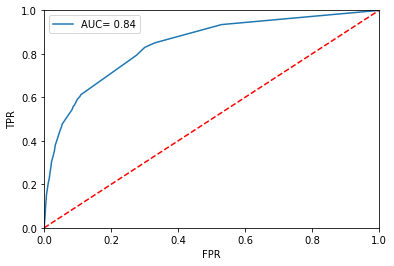

In [78]:
from sklearn.metrics import roc_curve,auc

fpr1,tpr1,threshold1=roc_curve(y_test,y_score1)
auc_values1=auc(fpr1,tpr1)

plt.figure()
plt.plot(fpr1,tpr1,label='AUC=% 0.2f'%auc_values1)
plt.legend()
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

- 由此可见，模型预测的效果很好